# CS 109A/AC 209A/STAT 121A Data Science: Airbnb Project


## Build an Improved Model


**Harvard University**<br>
**Fall 2016**<br>
**Team: Stephen Camera-Murray, Himani Garg, and Vijay Thangella**<br>
**TF: Christine Hwang ** 

## IV. Build an Improved Model

Import libraries

In [1]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# suppress warnings
warnings.filterwarnings ( 'ignore' )
%matplotlib inline

We begin by loading the listings dataset we saved after cleansing from milestone #4:

cleansed_listings.csv.gz - the New York City Airbnb listing data from January 2015 (cleansed)


In [2]:
# load listings data into a pandas df
listingsDF = pd.read_csv (  './datasets/cleansed_listings_with_target.tab.gz', sep = '\t', index_col = 'id', compression = 'gzip' )
listingsDF.drop('name', axis=1, inplace=True)
listingsDF.drop('square_feet', axis=1, inplace=True)
# display the first two rows
listingsDF.head ( n = 2 )


,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,minimum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
id,,,,,,,,,,,,,,,,,,,,,
1069266,Midtown East,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,2,3,...,7.0,9.0,9.0,10.0,9.0,1,21,21,1,Mid
2061725,Bushwick,Apartment,Private room,2,1.0,1.0,2.0,Real Bed,1,3,...,10.0,10.0,10.0,9.0,10.0,4,24,11,1,Low


Convert the response variables into individual classes of 0 ,1 and 2

In [3]:
listingsDF.loc[listingsDF['price_category'] == 'Low', 'price_category'] = 0
listingsDF.loc[listingsDF['price_category'] == 'Mid', 'price_category'] = 1
listingsDF.loc[listingsDF['price_category'] == 'High', 'price_category'] = 2



Lets dig into all these predictors to understand what predictors could be categorical and what predictors could be continous variables by looking at ranges and discrete values of all predictors

In [4]:
print listingsDF.shape
x_pred = listingsDF.values[:,:-1]
for i in range(x_pred.shape[1]):
    vals = np.unique(x_pred[:, i])
    cleanedvals = [x for x in vals if str(x) != 'nan']
    if len(cleanedvals) < 15 :
        print '(Categorical) {} unique values of predictor {} {}: {}'.format(len(cleanedvals), i,listingsDF[[i]].columns.values[0], cleanedvals)
    else:
        print '(Continuous) range of values of predictor', i, '{} : {} to {}'.format(listingsDF[[i]].columns.values[0],x_pred[:, i].min(), x_pred[:, i].max())
        

(19526, 28)
(Continuous) range of values of predictor 0 neighborhood : Allerton to Woodside
(Continuous) range of values of predictor 1 property_type : nan to Villa
(Categorical) 2 unique values of predictor 2 room_type: ['Entire home/apt', 'Private room']
(Categorical) 14 unique values of predictor 3 accommodates: [1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 12L, 15L, 16L]
(Categorical) 11 unique values of predictor 4 bathrooms: [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 4.5, 5.0, 5.5]
(Categorical) 1 unique values of predictor 5 bedrooms: [1.0]
(Categorical) 12 unique values of predictor 6 beds: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 16.0]
(Categorical) 5 unique values of predictor 7 bed_type: ['Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed']
(Categorical) 12 unique values of predictor 8 guests_included: [0L, 1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 10L, 15L, 16L]
(Continuous) range of values of predictor 9 minimum_nights : 1 to 30
(Continuous) range of values of pr

In [5]:
# Categoricals will be int or str (object), the rest float

# List of columns to be converted to floating point
to_float = ['accommodates', 'bathrooms', 'bedrooms', 'beds','guests_included','minimum_nights','maximum_nights', 
            'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
            'review_scores_rating', 'host_listing_count', 'months_as_host','months_since_first_review', 
            'months_since_last_review',]

# Converted columns to floating point
for feature_name in to_float:
    listingsDF[feature_name] = listingsDF[feature_name].astype(float)



In [6]:
#Encode categorical variables
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Categorical columns for use in one-hot encoder
categorical = (listingsDF.dtypes.values != np.dtype('float64'))

# Encode all labels
listingsDF = listingsDF.apply(encode_categorical)



In [7]:
x = listingsDF.values[:, :-1]
y = listingsDF.values[:, -1]

# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)

In [8]:
listingsDF.head ( n = 2 )

#listingsDF[listingsDF['price_category'] ==2]['neighborhood'].unique()


,neighborhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,minimum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_listing_count,months_as_host,months_since_first_review,months_since_last_review,price_category
id,,,,,,,,,,,,,,,,,,,,,
1069266,106,1,0,2.0,1.0,1.0,1.0,4,2.0,3.0,...,7.0,9.0,9.0,10.0,9.0,1.0,21.0,21.0,1.0,1
2061725,19,1,1,2.0,1.0,1.0,2.0,4,1.0,3.0,...,10.0,10.0,10.0,9.0,10.0,4.0,24.0,11.0,1.0,0


In [11]:
#Split the data into train and test datasets
print x.shape
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

(19526L, 227L)


### Establishing a baseline model  
  
Before we begin model building, we need to establish a baseline model to compare against our final model. Our goal is to provide pricing guidance to new owners who wish to list their property, we come up with three price groupings based on our data to have a nice balance between the groups and user-friendly ranges.  
  
We'll use the following models for our baselines (note: our baselines are intentionally very simple and don't use logistic regression, LDA, QDA, etc. as outlined in lab 10):
- Random selection
- Low model (choose "Low" category only)
- Mid model (choose "Mid" category only)
- High model (choose "High" category only)  

These models will be applied to our testing dataset. But first, let's look at the proportion of listings in the test set that fall in to each price category.

In [13]:
# function to compute the accuracy of a given model
score = lambda model, x_test, y_test: pd.Series ( [ model.score ( x_test, y_test ), 
                                                    model.score ( x_test [ y_test == 0 ],  y_test [ y_test == 0 ]  ),
                                                    model.score ( x_test [ y_test == 1 ],  y_test [ y_test == 1 ]  ),
                                                    model.score ( x_test [ y_test == 2 ], y_test [ y_test == 2 ] ),
                                                    f1_score    ( y_test, model.predict ( x_test ), average = "weighted" ) ],
                                                    index = [ 'Overall Accuracy', 'Accuracy on Low Category', 'Accuracy on Mid Category', 'Accuracy on High Category', 'F1 Score'  ])

In [14]:
# model predicting random values
class random_model ( object ):
    def predict ( self, x ):
        cats = [ 0, 1, 2 ]
        return np.random.choice ( cats, len ( x ), replace = True )

    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting Low
class low_model ( object ):
    def predict ( self, x ):
        return np.array ( [ 0 ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting Mid
class mid_model ( object ):
    def predict ( self, x ):
        return np.array ( [ 1 ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

# model predicting High
class high_model ( object ):
    def predict ( self, x ):
        return np.array ( [ 2 ] * len ( x ) )
    def score ( self, x, y ):
        y_pred = self.predict ( x )
        return ( y_pred == y ).sum() * 1. / len ( y )

Build our models and score.

In [16]:
# build and score our baseline models
random              = random_model()
random_model_scores = score ( random, x_test, y_test )

low                 = low_model()
low_model_scores    = score ( low, x_test, y_test )

mid                 = mid_model()
mid_model_scores    = score ( mid, x_test, y_test )

high                = high_model()
high_model_scores   = score ( high, x_test, y_test )

# print scores
scoreDF = pd.DataFrame ( { 'Random Model'              : random_model_scores,
                           'Low Model'                 : low_model_scores,
                           'Mid Model'                 : mid_model_scores,
                           'High Model'                : high_model_scores } )

scoreDF

,High Model,Low Model,Mid Model,Random Model
Overall Accuracy,0.061113,0.553090,0.385797,0.317856
Accuracy on Low Category,0.000000,1.000000,0.000000,0.342284
Accuracy on Mid Category,0.000000,0.000000,1.000000,0.327434
Accuracy on High Category,1.000000,0.000000,0.000000,0.321229
F1 Score,0.007039,0.393935,0.214807,0.378043


### Improve the model:

Lets run all the available models and see it to get results better than baseline models and also further improve the models if there is any nuances that we figure out that can improve these models

In [110]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1]),
                                                 model.score(x_test[y_test==2], y_test[y_test==2])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1','accuracy on class 2']
                                                )

In [111]:
# Run various models to check out the best model to move with


unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)

unweighted_log_scores = score(unweighted_logistic, x_test, y_test)
print 'unweighted log'


#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)

weighted_log_scores = score(weighted_logistic, x_test, y_test)
print 'weighted log'

#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score(lda, x_test, y_test)
print 'lda'

#QDA
qda = QDA()
qda.fit(x_train, y_train)

qda_scores = score(qda, x_test, y_test)
print 'qda'

#Decision Tree
tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)

tree_scores = score(tree, x_test, y_test)
print 'tree'

#Random Forest
rf = RandomForest(class_weight='balanced',oob_score= True)
rf.fit(x_train, y_train)

rf_scores = score(rf, x_test, y_test)

print 'rf'

#SVM
svm = SVC(kernel='rbf', class_weight = 'balanced')
svm= svm.fit(x_train, y_train)

svm_scores = score(svm, x_test, y_test)

print 'svm'

unweighted log
weighted log
lda
qda
tree
rf
svm


In [112]:
#Score Dataframe
score_df = pd.DataFrame({#'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'weighted logistic': weighted_log_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores,
                         'svm': svm_scores })
score_df



,lda,qda,rf,svm,tree,unweighted logistic,weighted logistic
overall accuracy,0.776033,0.093547,0.753670,0.516046,0.750427,0.55309,0.557187
accuracy on class 0,0.857716,0.033951,0.847222,0.553086,0.850000,1.00000,0.981481
accuracy on class 1,0.742035,0.038053,0.720354,0.489823,0.709292,0.00000,0.000000
accuracy on class 2,0.251397,0.983240,0.117318,0.346369,0.108939,0.00000,0.234637


So Looking at all the models, after balancing out the class_weights ,lda ,tree and random forest worked better. QDA is the only model which worked better with class2 than anyother model but did poor on class 0 and class1.Before we jump on to pick a model lets analyse to see which model would be best to move with
Logistic/weighted logistic Regression: Both these didnt do any good on class1 and more over to move with this model all of its basic assumptions need to be met
LDA: This is better but to move ahead the data distributon in two classes should be multivariate normal
QDA: To test for assumptions , like the data distributon in two classes to be multivariate normal is tough think to show as there are many predictors . More over QDA didnt perform much good.  However the assumptions must be met first before anything else. Either we can do pca analysis and reduce the dimensions so that proving the assumptions might not be difficult if we can get into 2 pca components 
SVM:no assuptions needed as long as support vectors dont change much with the change in dataste , SVM can be the best model. However SVM did equally bad on all classes.
Random Forest: Like lda and tree , random forest looked promising too and with no assumptions needed one could take advantage of it properly tuned

### Further improve the model:

#### Approach the imbalance problem:

When classes are imbalanced, one of the ways is to oversample the data or undersample the data or use class_weights. However here in this case instead of oversampling to make it balanced, we oversample the minority classes a bit more than what they are instead of making it completely balanced. And then we still can use class_weights to further balance. This way we can reduce the implicatins of too much oversampling




#### With Oversampling

In [113]:
# Over Sampling the minority classes to make it little less unbalanced , not making it totally balanced

data_class0= listingsDF[listingsDF.values[:,-1] ==0].values

print data_class0.shape
data_class1= listingsDF[listingsDF.values[:,-1] ==1].values
data_class2= listingsDF[listingsDF.values[:,-1] ==2].values

data_df_total = listingsDF.values.copy()
dataResampled_class1= data_class1.copy()
dataResampled_class2= data_class2.copy()
# Tha ranges are picked based on proportions of each class and making the ratio to 60:20:20
for i in range(10):
    k=1
    #dataResampled_class1= np.concatenate([dataResampled_class2,data_class2[::1]])
for i in range(1):
    dataResampled_class2= np.concatenate([dataResampled_class2,data_class2[::1]])
    
    

data_df_total= np.concatenate([dataResampled_class1,dataResampled_class2,data_class0])

np.random.shuffle(data_df_total)

print data_df_total.shape

(10761L, 28L)
(20692L, 28L)


In [119]:
# Get numpy array from data
x = data_df_total[:, :-1]
y = data_df_total[:, -1]

# Apply one hot endcoing
encoder = preprocessing.OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
x = encoder.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [124]:
print x_train.shape
print x_test.shape

(14484L, 227L)
(6208L, 227L)


In [125]:

unweighted_logistic = LogisticRegression()
unweighted_logistic.fit(x_train, y_train)

unweighted_log_scores = score(unweighted_logistic, x_test, y_test)
print 'unweighted log'


#Weighted logistic regression
weighted_logistic = LogisticRegression(class_weight='balanced')
weighted_logistic.fit(x_train, y_train)

weighted_log_scores = score(weighted_logistic, x_test, y_test)
print 'weighted log'

#LDA
lda = LDA()
lda.fit(x_train, y_train)

lda_scores = score(lda, x_test, y_test)
print 'lda'

#QDA
qda = QDA()
qda.fit(x_train, y_train)

qda_scores = score(qda, x_test, y_test)
print 'qda'

#Decision Tree
tree = DecisionTree(max_depth=6)
tree.fit(x_train, y_train)

tree_scores = score(tree, x_test, y_test)
print 'tree'

#Random Forest
rf = RandomForest(class_weight='balanced',oob_score= True)
rf.fit(x_train, y_train)

rf_scores = score(rf, x_test, y_test)

print 'rf'

#SVM
svm = SVC(kernel='rbf', class_weight = 'balanced')
svm= svm.fit(x_train, y_train)

svm_scores = score(svm, x_test, y_test)

print 'svm'

unweighted log
weighted log
lda
qda
tree
rf
svm


In [126]:
#Score Dataframe
score_df = pd.DataFrame({#'knn': knn_scores, 
                         'unweighted logistic': unweighted_log_scores,
                         'weighted logistic': weighted_log_scores,
                         'lda': lda_scores,
                         'qda': qda_scores,
                         'tree': tree_scores,
                         'rf': rf_scores,
                         'svm': svm_scores })
score_df

,lda,qda,rf,svm,tree,unweighted logistic,weighted logistic
overall accuracy,0.750161,0.138209,0.774646,0.544459,0.720522,0.512887,0.512887
accuracy on class 0,0.866520,0.025440,0.854585,0.559673,0.846106,1.000000,0.999372
accuracy on class 1,0.698712,0.036481,0.681116,0.463948,0.727468,0.000000,0.000000
accuracy on class 2,0.389049,0.997118,0.721902,0.744957,0.121037,0.000000,0.002882


With just a little oversampling we can see very high improved performance from RF model on all 3 classes compared to any other models. With no doubt we can pick this RF model and tune it to further improve the model

Probably before oversampling , the minority classes are too low to be considred in every oob sample that has been used, which might be  the reason why RF before oversampling fared very bad on class2. However with littlebit oversampling every oob sample would have had enough minority classes to be modeled upon and could be the reason why this RF fared better 
Since this is random forest we dont have to necessarily do cross validation as we use OOB samples. so over sampling the data a bit gives random forest more look at the full dataset at the same time we made minority classes little less minor. All the crossvalidation testing will be done in OOB samples

#### Tune the hyper parameters

In [132]:
parameters = {"n_estimators": [ 100,200,300,400,500]}

cv_rfc = GridSearchCV(RandomForest(oob_score=True, max_features='auto'), param_grid=parameters, n_jobs=5, cv=5)

cv_rfc.fit(x_train, y_train)

print cv_rfc.best_params_

{'n_estimators': 400}


In [135]:
depths = range(5, 70,2)
kf = KFold(len(x_train), n_folds=5)
profits = []

for depth in depths:
    print 'depth:', depth
    validation_profits = []
    for train_index, test_index in kf:
        x_validate_train, x_validate_test = x_train[train_index], x_train[test_index]
        y_validate_train, y_validate_test = y_train[train_index], y_train[test_index]
        
        clfForest = RandomForest(class_weight ='balanced',max_depth = depth, oob_score = True,
                                        n_estimators =400, )
        clfForest.fit(x_validate_train, y_validate_train)
        score=clfForest.score(x_validate_test,y_validate_test)
        y_pred = clfForest.predict(x_validate_test)
        validation_profits.append(score)
        
    profits.append(np.mean(validation_profits))

best_depth = np.argmax(profits) + 1
print best_depth


depth: 5
depth: 7
depth: 9
depth: 11
depth: 13
depth: 15
depth: 17
depth: 19
depth: 21
depth: 23
depth: 25
depth: 27
depth: 29
depth: 31
depth: 33
depth: 35
depth: 37
depth: 39
depth: 41
depth: 43
depth: 45
depth: 47
depth: 49
depth: 51
depth: 53
depth: 55
depth: 57
depth: 59
depth: 61
depth: 63
depth: 65
depth: 67
depth: 69
19


Depth = 19 is the corresponding max_dapth= 41

In [ ]:

parameters = {"max_depth": [22,26,28,30,32,34,35,36,37,38,39,40], "n_estimators": [ 100,200,300,400,500]}

cv_rfc = GridSearchCV(RandomForest(oob_score=True, max_features='auto'), param_grid=parameters, n_jobs=5, cv=5)

cv_rfc.fit(x_train, y_train)

print cv_rfc.best_params_

In [141]:
target_names = ['class 0', 'class 1', 'class_2']

clfForest = RandomForest(class_weight ='balanced',max_depth = 41,oob_score = True,n_estimators =400,
                           max_features ='sqrt')
#clfForest = RandomForest(class_weight='balanced',oob_score= True)
clfForest=clfForest.fit(x_train, y_train)
y_pred=clfForest.predict(x_train)
score=clfForest.score(x_train,y_train)
print score
print y_pred.shape
print y_train.shape
print confusion_matrix(y_train, y_pred)
print(classification_report(y_train, y_pred,target_names =target_names))
cm = confusion_matrix(y_train,y_pred)
print "Train data Accuracy on Low price category:" , cm[0,0]/(np.sum(cm[0]) *1.0)
print "Train data Accuracy on Mid price category: " , cm[1,1]/(np.sum(cm[1]) *1.0)
print "Train data Accuracy on HIgh price category: " , cm[2,2]/(np.sum(cm[2]) *1.0)
y_pred_test=clfForest.predict(x_test)
score=clfForest.score(x_test,y_test)
print score
cm = confusion_matrix(y_test,y_pred_test)
print confusion_matrix(y_test,y_pred_test)
print classification_report(y_test, y_pred_test,target_names =target_names)
print "Test data Accuracy on Low price category: " , cm[0,0]/(np.sum(cm[0]) *1.0)
print "Test data Accuracy on Mid price category: " , cm[1,1]/(np.sum(cm[1]) *1.0)
print "Test data Accuracy on High price category: " , cm[2,2]/(np.sum(cm[2]) *1.0)




0.998550124275
(14484L,)
(14484L,)
[[7576    0    1]
 [  17 5249    3]
 [   0    0 1638]]
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      7577
    class 1       1.00      1.00      1.00      5269
    class_2       1.00      1.00      1.00      1638

avg / total       1.00      1.00      1.00     14484

Train data Accuracy on Low price category: 0.999868021644
Train data Accuracy on Mid price category:  0.996204213323
Train data Accuracy on HIgh price category:  1.0
0.796391752577
[[2711  466    7]
 [ 542 1707   81]
 [  22  146  526]]
             precision    recall  f1-score   support

    class 0       0.83      0.85      0.84      3184
    class 1       0.74      0.73      0.73      2330
    class_2       0.86      0.76      0.80       694

avg / total       0.80      0.80      0.80      6208

Test data Accuracy on Low price category:  0.851444723618
Test data Accuracy on Mid price category:  0.732618025751
Test data Accuracy on 

The overall Accuracy , class accuracies have been improved from the previous model. One more thing not to overlook is the fact that the precision , recall and f1-scores for all 3 classes are very good to consider this a nice model


### Goodness of the fit (ROC curve)

Lets check the goodness of the this model fit to see if the model that we built is a reasonable model to be used. For this lets build the ROC curve for this model. However here ,we have 3 classes ,so lets get a ROC curve for every class against the rest of the classes and see how this model performed on each class

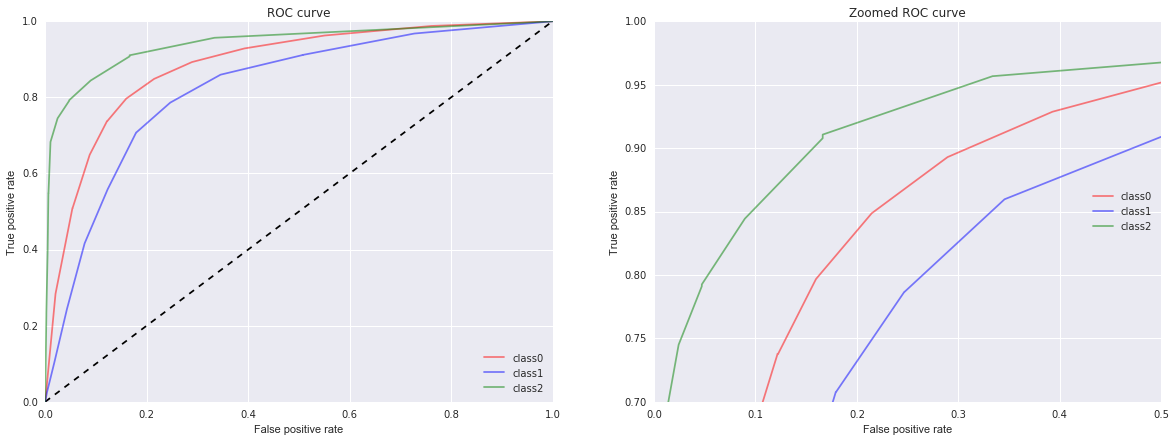

In [145]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(221)
ax1.plot([0, 1], [0, 1], 'k--')
ax2 = fig.add_subplot(222)
ax2.plot([0, 1], [0, 1], 'k--')

clfForest = RandomForest(class_weight ='balanced',max_depth = 41, oob_score = True,n_estimators =400,
                         criterion ='gini' , max_features ='sqrt')
color =['r','b','g']
clfForest = clfForest.fit(x_train, y_train)
for i in range(3):
    
    y_pred_rf = rf.predict_proba(x_test)[:, i]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf,pos_label=i)
    ax1.plot(fpr_rf, tpr_rf, label='class' + str(i), color=color[i],alpha=0.5)
    ax2.plot(fpr_rf, tpr_rf, label='class' + str(i), color=color[i],alpha=0.5)
    
ax1.set_xlabel('False positive rate')
ax2.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax2.set_ylabel('True positive rate')
ax1.set_title('ROC curve')
ax2.set_title('Zoomed ROC curve')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax2.set_ylim(0.7,1)
ax2.set_xlim(0,0.5)
plt.show()
    